# ToryNLP

This tutorial will analyze the textual platitudes contained in the resignation letters of some of the UK's main conservative party members.

The files can be found in the repository, and include:

1. Rishi Sunak's resignation letter [text]
2. Sajid Javid's resignation letter [text]
3. John Glen's resignation letter [image]

We'll apply basic (but effective-enough) NLP techniques in Python to these letters, and will also briefly look at OCR (optical character recognition) to translate John Glen's murky image letter to text.

## Reading the Text Files

Let's read in Sunak and Javid's resignation letters from the files.

In [39]:
rishi_txt = 'rishisunak.txt'
javid_txt = 'javid.txt'

with open(rishi_txt, 'r') as rf, open(javid_txt, 'r') as jf:
    rishi = rf.read()
    javid = jf.read()
    
print(rishi[:100], end="\n\n-----\n\n")
print(javid[:100])

Dear Prime Minister,

It is with deep sadness that I am writing to you to resign from the Government

-----

It was a privilege to have been asked to come back into Government to serve as Secretary of State fo


In this tutorial, we'll touch upon the following NLP/text topics:

* Sentiment Analysis
* Wordcloud
* Keyword analysis
* Document Similarity
* Summarization
* NER
* OCR on John Glen

## Sentiment Analysis with TextBlob and NLTK

Sentiment analysis is a technique in NLP that's used to classify whether data is positive, negative or neutral.

Example:

1. My government has been an unmitigated shambles. (negative sentiment)
2. We managed to get Brexit done. (positive sentiment)
3. The door is white. (neutral sentiment)

We'll use a library called TextBlob to get the sentiment from these resignation texts.

https://textblob.readthedocs.io/en/dev/

In [40]:
!pip install textblob

Some metrics you can look at with TextBlob:

* **polarity** - is a float within the range [-1.0, 1.0] where -1.0 is a highly negative sentiment and 1.0 is highly positive sentiment. 0 is neutral.
* **subjectivity/objectivity identification** - reports a float within the range [0.0, 1.0] where 0.0 is a very objective sentence and 1.0 is very subjective.

We will focus on polarity for this tutorial.

In [41]:
from textblob import TextBlob

TextBlob(rishi).sentiment

Sentiment(polarity=0.07474426807760143, subjectivity=0.5240652557319223)

We're interested in splitting the text into sentences, and analyzing the polarity of each sentence.

We can use NLTK's `tokenize.sent_tokenize(text)` function to do a reasonable job of splitting text into its sentences. From there, we can pass each sentence to `TextBlob`.

(later, we'll see that `Spacy` can be used for sentence splitting, too).

In [121]:
# split Rishi into sentences
from nltk import tokenize

# create a list of sentences from the source text
sentences = tokenize.sent_tokenize(rishi)

# print out polarities
for sentence in sentences:
    print(TextBlob(sentence).polarity)

0.0
0.26666666666666666
-0.3333333333333333
-0.002777777777777768
0.1130952380952381
0.15
0.3333333333333333
0.0
0.0
0.09999999999999999
0.0
0.0
0.036111111111111115
0.0
-0.11833333333333333
0.0
0.2916666666666666
0.3111111111111111
0.03333333333333334
-0.5
0.6


We can find the sentences with the minimum and maximum polarity, i.e. the most **negative** sentence and the most **positive** sentence.

In [123]:
polarities = [TextBlob(sentence).polarity for sentence in sentences]

min_pol = min(polarities)
max_pol = max(polarities)

# find the index of the sentence w/ min and max polarities
neg_sentiment_index = polarities.index(min_pol)
pos_sentiment_index = polarities.index(max_pol)

print(sentences[neg_sentiment_index], end="\n\n")
print(sentences[pos_sentiment_index])

I am sad to be leaving Government, but I have reluctantly come to the conclusion that we cannot continue like this.

Kind regards,

Rishi Sunak


Notice how the last sentence (the 'kind regards') has the most positive polarity in Rishi's entire resignation letter.

To ignore that, we can remove that when creating the polarities list:

`polarities = [TextBlob(sentence).polarity for sentence in sentences[:-1]`

In [124]:
polarities = [TextBlob(sentence).polarity for sentence in sentences[:-1]]

min_pol = min(polarities)
max_pol = max(polarities)

# find the index of the sentence w/ min and max polarities
neg_sentiment_index = polarities.index(min_pol)
pos_sentiment_index = polarities.index(max_pol)

print(sentences[neg_sentiment_index], end="\n\n")
print(sentences[pos_sentiment_index])

I am sad to be leaving Government, but I have reluctantly come to the conclusion that we cannot continue like this.

I have been loyal to you.


Let's now look at **all** negative sentences.

We'll convert the lists to Numpy arrays to use some nice indexing and slicing functionality.

In [126]:
import numpy as np

polarities_arr = np.array(polarities)
sentences_arr = np.array(sentences)


neg_idxs = np.argwhere(polarities_arr < 0).flatten()
print(sentences_arr[neg_idxs])

['To leave ministerial office is a serious matter at any time.'
 'For me to step down as Chancellor while the world is suffering the economic consequences of the pandemic, the war in Ukraine and other serious challenges is a decision that I have not taken lightly.'
 'We both want a low-tax, high-growth economy and world-class public services, but this can only be responsibly delivered if we are prepared to work hard, make sacrifices and take difficult decisions.'
 'I am sad to be leaving Government, but I have reluctantly come to the conclusion that we cannot continue like this.']


Try the above for positive sentiment, too.

To get the same for Javid, run with his resignation letter passed to TextBlob originally.

### WordCloud

Python has a nice wordcloud package that can be used to generate wordclouds from raw text. Let's apply this to the resignation letters.

In [45]:
!pip install wordcloud

### RishiCloud

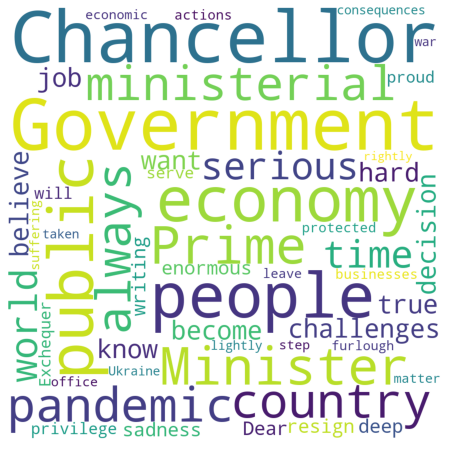

In [128]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt


# this code creates the WordCloud
wordcloud = WordCloud(
    max_words=50,
    background_color='white',
    width=1000,
    height=1000,
    stopwords=set(STOPWORDS),
    min_font_size=10
).generate(rishi)


# we plot the wordcloud with pyplot
plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.axis("off")
 
plt.show()

### JavidCloud

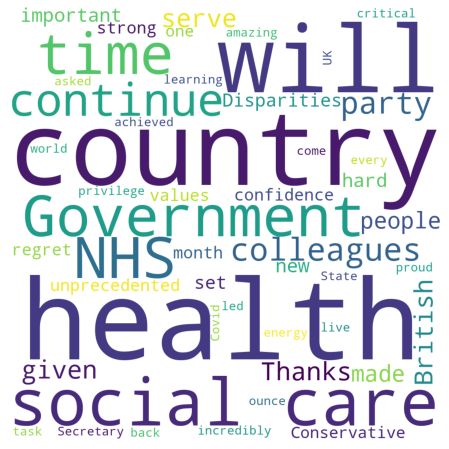

In [144]:
# this code creates the WordCloud
wordcloud = WordCloud(
    max_words=50,
    background_color='white',
    width=1000,
    height=1000,
    stopwords=set(STOPWORDS),
    min_font_size=10
).generate(javid)


# we plot the wordcloud with pyplot
plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.axis("off")
 
plt.show()

## Keyword Analysis

Texts usually contain a lot of fluff, along with some keywords.

This is particularly true of Conservative party resignation letters.

To attempt to find keywords, we'll use [YAKE](https://github.com/LIAAD/yake) - an unsupervised keyword extraction library. Alternatively, you may want to look at [KeyBERT](https://github.com/MaartenGr/KeyBERT/), which is another easy-to-use package that uses BERT Embeddings for the keyword extraction task.

In [47]:
!pip install git+https://github.com/LIAAD/yake

  Cloning https://github.com/LIAAD/yake to c:\users\lyle\appdata\local\temp\pip-req-build-w2ab01xq
  Created wheel for yake: filename=yake-0.4.8-py2.py3-none-any.whl size=62855 sha256=e09c823d380ca6e53da877c47a07222242075887ef60c3c1a229a3e24ba06123
  Stored in directory: C:\Users\Lyle\AppData\Local\Temp\pip-ephem-wheel-cache-tldxn5gf\wheels\91\6a\18\ab7d2fc1e58b6ed936dbe90881425aea909bae3f98dae32f66
Successfully built yake


With the output, the LOWER the score, the more relevant the keyword is.

In [48]:
import yake

# experiment with the "n" parameter: 1,3,5
kw_extractor = yake.KeywordExtractor(top=20, stopwords=set(STOPWORDS), n=5)
keywords = kw_extractor.extract_keywords(rishi)

keywords

[('resign from the Government', -4.135201066112525),
 ('writing to you to resign', -0.17901485482737303),
 ('sadness that I am writing', -0.1704023239257655),
 ('Dear Prime Minister', 0.012947932522831057),
 ('deep sadness', 0.023462384533945464),
 ('Dear Prime', 0.04124410482485667),
 ('Prime Minister', 0.04328169038576637),
 ('Prime Minister and Chancellor remain', 0.050428022981982124),
 ('Chancellor', 0.05528272312682103),
 ('Prime Minister and Chancellor', 0.06886611458078026),
 ('pandemic we protected people jobs', 0.07745932303411106),
 ('Government', 0.07787353187700362),
 ('enormous privilege to serve', 0.08322905566234365),
 ('protected people jobs and businesses', 0.0937275764505945),
 ('protected people jobs', 0.10477034060503511),
 ('privilege to serve our country', 0.10667911949186157),
 ('public rightly expect government', 0.12600645524417578),
 ('serve our country as Chancellor', 0.13162238613272245),
 ('Dear', 0.1403362132997231),
 ('Prime', 0.14112682690367676)]

In [49]:
# with Javid
keywords = kw_extractor.extract_keywords(javid)

keywords

[('Care at such a critical', -2.6769841387532596),
 ('privilege to have been asked', -0.21151181086909965),
 ('Secretary of State', 0.003944954715376664),
 ('Secretary of State for Health', 0.00421696947885952),
 ('serve as Secretary of State', 0.004345598079623687),
 ('asked to come back', 0.0047283899426817134),
 ('Social Care', 0.02006878619272193),
 ('come back into Government', 0.02232716251762919),
 ('NHS and adult social care', 0.025313912899787225),
 ('Health and Social Care', 0.025502633824616316),
 ('Health Disparities White Paper', 0.025590750373337023),
 ('asked to come', 0.027547732722144724),
 ('come back', 0.027547732722144724),
 ('NHS and social care staff', 0.03811141762224926),
 ('NHS and social care', 0.04107596271226731),
 ('Health', 0.05370692720907375),
 ('State for Health and Social', 0.05530691690591558),
 ('Health Disparities White', 0.05765302632390635),
 ('adult social care', 0.062108449666109275),
 ('Secretary', 0.0626853507643111)]

## Document Similarity 

This is a core topic in text analytics and information retrieval - the idea of taking two pieces of text, and getting a measure of how **similar** (or dissimilar) they are.

I was hypothesizing that Tory resignation letters would be fairly similar documents, with overlapping themes and nauseating drivel abound. Let's test...

We're going to use a very simple set-based similarity metric called the **Jaccard Similarity** - and to get a good measure, we need to preprocess and normalize the text in various ways. 

So, we'll start by normalizing the two documents, by doing the following:

* Lowercasing text
* Removing punctuation
* Stemming with `PorterStemmer`
* Tokenizing

Once we've done this, we'll compute the `Jaccard Similarity` - a simple set-based metric for computing similarity between two documents. This has range [0,1], where 0 would entail the texts contain no common elements, and 1 entailing that the texts contain the exact same vocabulary.

In [146]:
# we'll use NLTK word_tokenize to create tokens from the documents.
# however, as seen below, these need normalized (lowercase, punct. removal, etc)

tokenize.word_tokenize(rishi)[:20]

['Dear',
 'Prime',
 'Minister',
 ',',
 'It',
 'is',
 'with',
 'deep',
 'sadness',
 'that',
 'I',
 'am',
 'writing',
 'to',
 'you',
 'to',
 'resign',
 'from',
 'the',
 'Government']

We'll write a preprocessing function that will perform the lowercasing, punctuation removal, and stemming of the source text.

Write this function stepwise, and show output at each stage by calling it.

In [51]:
from nltk.stem import PorterStemmer

def preprocess(text):
    tokens = tokenize.word_tokenize(text)
    tokens = [t.lower() for t in tokens if t.isalnum()]
    porter = PorterStemmer()
    tokens = [porter.stem(t) for t in tokens]
    
    # print(tokens[:20])
    return tokens
    
preprocess(rishi)[:20]

['dear',
 'prime',
 'minist',
 'it',
 'is',
 'with',
 'deep',
 'sad',
 'that',
 'i',
 'am',
 'write',
 'to',
 'you',
 'to',
 'resign',
 'from',
 'the',
 'govern',
 'it']

Once we've done this, we can compute a similarity between the two documents.

**Jaccard similarity** is equal to the size of the intersection divided by the size of the union. It looks at how close the intersection is to the union - the larger this intersection, the more "similar" the documents are, and the nearer the metric will be to the upper bound of 1.

![image.png](https://www.gstatic.com/education/formulas2/443397389/en/jaccard_index.svg)

In [52]:
from typing import List


def jaccard(tokens: List, tokens2: List) -> float:
    s1 = set(tokens)
    s2 = set(tokens2)
    
    intersection = s1 & s2
    union = s1 | s2
    return len(intersection) / len(union)


jaccard(preprocess(rishi), preprocess(javid))

0.25271739130434784

The similarity is 0.25! Let's compare with a random article from the BBC.

https://www.bbc.co.uk/news/business-62075834

In [53]:
house_prices = """House prices hit a fresh record in June, according to Halifax, despite expectations the rising cost of living in the UK would dampen demand.

The mortgage lender said the average house price reached £294,845 in June after rising by 1.8% - the steepest monthly increase since 2007.

Halifax said a lack of available homes for sale was lifting prices as well as a shift towards people buying larger, detached homes.

But it expects price growth will slow.

Halifax said that the housing market had, so far, been largely insulated from the rising cost of living.

"This is partly because, right now, the rise in the cost of living is being felt most by people on lower incomes, who are typically less active in buying and selling houses.

"In contrast, higher earners are likely to be able to use extra funds saved during the pandemic," said Halifax managing director Russell Galley.

House prices rose by 13% in the year to June, which Halifax said was the highest rate since late 2004.

Slowdown expected
It said demand for bigger, detached houses had lifted prices for these properties by 13.9% over the past year compared to a 7.6% increase for flats.

Halifax expects, however, that the "increased pressure on household budgets from inflation and higher interest rates should weigh more heavily on the housing market, given the impact this has on affordability"

"So while it may come later than previously anticipated, a slowing of house price growth should still be expected in the months ahead," said Mr Galley.

The Bank of England has announced a series of interest rate rises in recent months in an attempt to stem soaring inflation, lifting mortgage rates for some borrowers.

Northern Ireland saw the largest rise in house prices, with an increase of 15.2% in the year to June to take the average to £187,833. Wales also recorded sharp growth of 14.3% to £219,281.

The average house price in Scotland also hit a new record, rising 9.9% over the year to £201,549, "breaking through £200,000 for the first time in history" said Halifax."""

In [54]:
jaccard(preprocess(house_prices), preprocess(rishi))

0.11818181818181818

Note: if we had a vectorized our text using Bag of Words, Word2Vec, etc, then we could compute cosine similarities. This is a geometric interpretation of document similarity.

## Summarization

Summarization cuts a larger piece of text down to its most important content.

We'll use `sumy` for document summmarization. This provides implementations of different algorithms for summarization - Latent Semantic Analysis, TextRank, Lex-Rank, etc.

https://pypi.org/project/sumy/

In [55]:
!pip install sumy

In [140]:
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.nlp.stemmers import Stemmer
from sumy.summarizers.lsa import LsaSummarizer
from sumy.summarizers.text_rank import TextRankSummarizer

# create an English parser from Rishi's text, and a stemmer
parser = PlaintextParser.from_string(rishi, Tokenizer('english'))
stemmer = Stemmer('english')

#### try both these algorithms
# summarizer = LsaSummarizer(stemmer)
summarizer = TextRankSummarizer(stemmer)

N = 3
for sentence in summarizer(parser.document, N):
    print(sentence, end="\n\n")

It has been an enormous privilege to serve our country as Chancellor of the Exchequer, and I will always be proud of how during the pandemic we protected people's jobs and businesses through actions such as furlough.

For me to step down as Chancellor while the world is suffering the economic consequences of the pandemic, the war in Ukraine and other serious challenges is a decision that I have not taken lightly.

That is the nature of the collective government upon which our system relies and it is particularly important that the Prime Minister and Chancellor remain united in hard times such as those we are experiencing today.



## NER

Named Entity Recognition is the process of finding "entities" in text - people, places, dates, organisations, companies, etc.

We'll use [Spacy](https://spacy.io/) to do this task. Spacy is an excellent NLP package!

Note: below, we install Spacy, but also load a **language model** - the English small model, which is good enough for basic applications. 

More advanced language models are available for Spacy, in numerous languages.

In [57]:
!pip install spacy
!python -m spacy download en_core_web_sm

[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [58]:
import spacy

# load the language model
nlp = spacy.load("en_core_web_sm")

In [141]:
# we use the language model to create a Document object
doc = nlp(rishi)
doc

Dear Prime Minister,

It is with deep sadness that I am writing to you to resign from the Government.

It has been an enormous privilege to serve our country as Chancellor of the Exchequer, and I will always be proud of how during the pandemic we protected people's jobs and businesses through actions such as furlough.

To leave ministerial office is a serious matter at any time. For me to step down as Chancellor while the world is suffering the economic consequences of the pandemic, the war in Ukraine and other serious challenges is a decision that I have not taken lightly.

However, the public rightly expect government to be conducted properly, competently and seriously. I recognise this may be my last ministerial job, but I believe these standards are worth fighting for and that is why I am resigning.

I have been loyal to you. I backed you to become leader of our party and encouraged others to do so. I have served as your Chancellor with gratitude that you entrusted me with stewards

This Document object is made up of a sequence of Token objects, and the Document also contains a number of useful attributes - for example, sentences.

In [73]:
list(doc.sents)[0]

Dear Prime Minister,

It is with deep sadness that I am writing to you to resign from the Government.

So Spacy can easily find sentences in texts, as an alternative to NLTK.

It can also find **entities** - the document has an `.ents` attribute that can be used to access these entities.

In [74]:
doc.ents

(Exchequer, Ukraine, British, 2019, Brexit, today, next week, Rishi Sunak)

In [77]:
# Note: NORP entity type = nationalities or religious and political groups

for ent in doc.ents:
    print(ent.text, ent.label_)

Exchequer ORG
Ukraine GPE
British NORP
2019 DATE
Brexit PERSON
today DATE
next week DATE
Rishi Sunak PERSON


In [79]:
# JAVID!

doc = nlp(javid)

for ent in doc.ents:
    print(ent.text, ent.label_)

State for Health and Social Care ORG
UK GPE
British NORP
months DATE
NHS ORG
70 per cent MONEY
NHS ORG
the Health Disparities White Paper ORG
British NORP
last month DATE
three years DATE
Corbynism NORP
Brexit PERSON
Conservative Party ORG
one CARDINAL
first ORDINAL
one CARDINAL
NHS ORG


## OCR

We have another file here, with a resignation letter from John Glen.

You **must** download and install Tesseract OCR on your computer. Get it here: https://github.com/UB-Mannheim/tesseract/wiki

Note where this is downloaded to. For me: `C:\Program Files\Tesseract-OCR\tesseract.exe`

Then, you can use the Python wrapper, `pytesseract`. This requires you to tell it where the `tesseract` executable exists, hence why we need to take note of this path above.

In [80]:
!pip install pytesseract

With `pytesseract`, we can extract the text in the image. However, we first need to load the image, and we'll use `Pillow` for that.

(-0.5, 829.5, 539.5, -0.5)

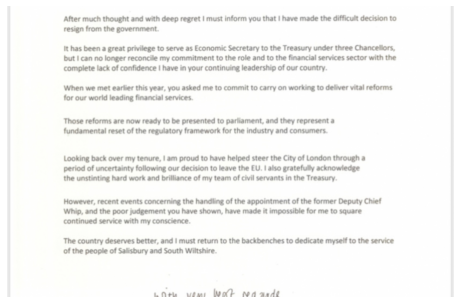

In [142]:
from PIL import Image

# create pillow Image object from the resignation JPG file
img = Image.open('johnglen.jpg')

# display using plt.imshow
plt.subplots(figsize=(8,8))
plt.imshow(img)
plt.axis('off')

With the image in-memory, we can now use `pytesseract` to attempt to read the text from that image into our code.

Notably, the package provides an `image_to_string(img)` function for this purpose.

In [96]:
import pytesseract

# set the path to the Tesseract executable
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

# extract the text from the image
text = pytesseract.image_to_string(img)

text

'‘After much thought and with deep regret I must inform you that | have made the difficult decision to\nresign from the government.\n\nIt has been a great privilege to serve as Economic Secretary to the Treasury under three Chancellors,\nbut | can no longer reconcile my commitment to the role and to the financial services sector with the\n‘complete lack of confidence | have in your continuing leadership of our country.\n\nWhen we met earlier this year, you asked me to commit to carry on working to deliver vital reforms\nfor our world leading financial services.\n\nThose reforms are now ready to be presented to parliament, and they represent a\nfundamental reset of the regulatory framework for the industry and consumers.\n\nLooking back over my tenure, ! am proud to have helped steer the City of London through a\nperiod of uncertainty following our decision to leave the EU. | also gratefully acknowiedge\nthe unstinting hard work and brilliance of my team of civil servants in the Treasur

Once the text is in our app, we can apply the same techniques as before (sentiment analysis, entity recognition, summarization, etc).

In [143]:
# entity recognition
doc = nlp(text)

doc.ents

(Treasury,
 three,
 earlier this year,
 the City of London,
 EU,
 Treasury,
 Salisbury,
 South Wiltshire)

In [119]:
# sentiment 
for sent in doc.sents:
    print(TextBlob(sent.text).polarity)


-0.09999999999999999
0.275
0.03333333333333333
0.2
0.0
0.4
-0.2916666666666667
-0.26666666666666666
0.5
0.0


NOTE: There's a Spacy extension called `spacytextblob`: https://spacy.io/universe/project/spacy-textblob

For easier integration of TextBlob w/ Spacy.

Additionally, there's a nice Spacy extension called `pytextrank` for phrase extraction, as well as extractive summarization: https://github.com/DerwenAI/pytextrank